In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import numpy as np
import matplotlib.pyplot as plt


from ase.build import graphene
from ase import Atoms

from abtem import show_atoms

# Creating an orthogonal periodic super cell

abTEM requires an orthogonal periodic atomic structure, this notebook shows how to create such a structure.

## Hexagonal structures

We will build our understanding of the problem by first solving the important special case of hexagonal structures. Here we create a minimal unit cell of graphene and show a corresponding repeated supercell.

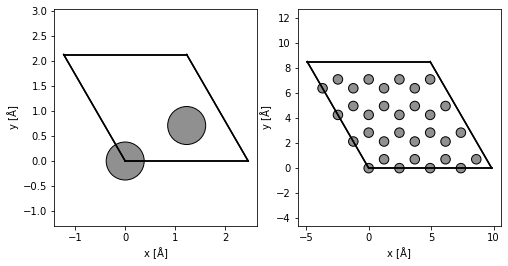

In [32]:
graphene_atoms = graphene()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
show_atoms(graphene_atoms, ax=ax1);
show_atoms(graphene_atoms * (4, 4, 1), ax=ax2);

To make the structure orthogonal we need to change the second lattice vector `b` such that it only has a component in the `y`-direction.

In [33]:
a, b, c = graphene_atoms.cell

print(f'a = {a}')
print(f'b = {b}')

a = [2.46 0.   0.  ]
b = [-1.23        2.13042249  0.        ]


First, let's see what happens if we naively make the cell orthgonal by setting the x-component of the second lattice vector to zero.

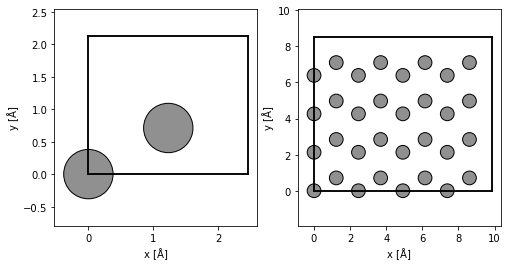

In [34]:
wrong_graphene_atoms = graphene_atoms.copy()
wrong_graphene_atoms.cell[1] = [0., b[1], 0.]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
show_atoms(wrong_graphene_atoms, ax=ax1);
show_atoms(wrong_graphene_atoms * (4, 4, 1), ax=ax2);

The result is a cell that is obviously orthogonal, however, when we repeat the cell, we see that it no longer tiles to produce the graphene structure.

To ensure periodicity we have to make a new lattice vector by combining the old ones:
$$
b' = n \cdot b + m \cdot a ,
$$
where `n` and `m` are integers, and to ensure orthogonality we want the `x`-component of `b'` to be zero:
$$
b_x' = 0
$$

Combning the conditions we get
$$
n = -m \frac{a_x}{b_x} ,
$$

This has infinitely many solutions, but we get the smallest cell by choosing $m = 1$ in which case $n = 2$, because for the ratio of the x-components in the hexagonal cell are exactly `-2`.

In [25]:
print(f'bx / ax = {a[0] / b[0]}')

bx / ax = -2.0


This is implemented below. Note that we don't multiply the lattice vector by two we repeat the atoms object.

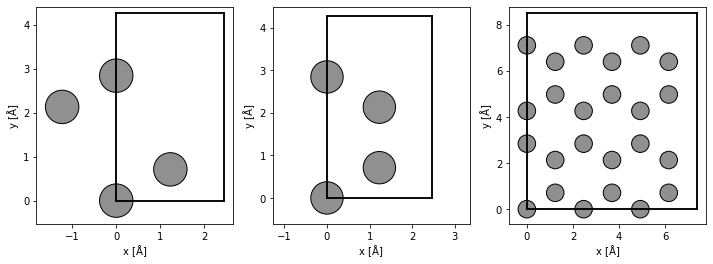

In [35]:
orthogonal_graphene_atoms = graphene_atoms * (1, 2, 1) # multiply the b lattice vector by 2 (and a lattice vector by 1)
orthogonal_graphene_atoms.cell[1] += a # add the a lattice vector

wrapped_orthogonal_graphene_atoms = orthogonal_graphene_atoms.copy()
wrapped_orthogonal_graphene_atoms.wrap() # "wrap" the atoms outside the cell back into the cell (not strictly necessary due to periodic boundaries)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
show_atoms(orthogonal_atoms, ax=ax1)
show_atoms(wrapped_orthogonal_graphene_atoms, ax=ax2)
show_atoms(wrapped_orthogonal_graphene_atoms * (3, 2, 1), ax=ax3);

## Monoclinic structures

The solution above also works for monoclinic cells. However, we also see that the minimum values of `n` and `m` and hence the number of repetitions required, is entirely dependent on the ratio of the lattice vectors. This ratio can  take on any value in theory, e.g. if the ratio is $-5 / 3$ then $m = 3$ and $n=5$ is the smallest solution. 

This opens two problems, if the structure is very close to orthogonal, the ratio and hence the number of repetitions can be huge, and if the ratio is irrational there will not even be an integer solution solution! 

Neither of these problems are issues in practive, as we can always find an approximate solution by applying a tiny bit of strain to the unit cell, such that the ratio is a reasonable rational approximation (and your computers representation of numbers is rational. For example, if the ratio somehow happens to be $\pi$, we can apply strain such the the ratio becomes $22/7$

$$
n = m \pi \approx m \frac{22}{7}
$$

and we get the solution

$$
m = 7, \quad n = 22
$$

To test this we create the monoclinic structure, `Ce4Mg8`: 

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

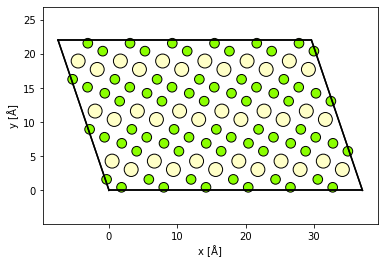

In [163]:
a = [12.371731149269, 0.000000000000, 0.000000000000]
b = [-2.487006312587, 7.329410702560, 0.000000000000]
c = [0.000000000000, 0.000000000000, 3.740697000000]

symbols = ['Ce'] * 4 + ['Mg'] * 8

scaled_positions = \
 [[0.845996463393, 0.416030792646, 0.000000000000],
  [0.345996463393, 0.416030792646, 0.500000000000],
  [0.154003536607, 0.583969207354, 0.000000000000],
  [0.654003536607, 0.583969207354, 0.500000000000],
  [0.160109395756, 0.060441354728, 0.000000000000],
  [0.660109395756, 0.060441354728, 0.500000000000],
  [0.515356394233, 0.218784113099, 0.000000000000],
  [0.015356394233, 0.218784113099, 0.500000000000],
  [0.484643605767, 0.781215886901, 0.000000000000],
  [0.984643605767, 0.781215886901, 0.500000000000],
  [0.839890604244, 0.939558645272, 0.000000000000],
  [0.339890604244, 0.939558645272, 0.500000000000]]
    
ce_mg_atoms = Atoms(symbols, scaled_positions=scaled_positions, cell=[a,b,c], pbc=True)

ce_mg_atoms = standardize_cell(ce_mg_atoms)

fig, ax = plt.subplots()

show_atoms(ce_mg_atoms * (3, 3, 1), ax=ax)

The lattice vector ratio is:

In [157]:
a = ce_mg_atoms.cell[0]
b = ce_mg_atoms.cell[1]

a[0] / b[0]

-4.974547546041347

We will use five as our close rational approximation, the descrepency will be made up by applying strain. 

We can use abTEM's `orthogonalize_cell` to achieve this:

In [158]:
from abtem.structures import orthogonalize_cell, standardize_cell

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

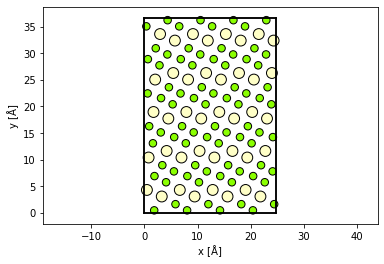

In [164]:
orthogonal_ce_mg_atoms, strain = orthogonalize_cell(ce_mg_atoms, limit_denominator=5, return_strain=True)

fig, ax = plt.subplots()
show_atoms(orthogonal_ce_mg_atoms * (2,1,1), ax=ax)

In [147]:
12.371731149269 / 2.0104492596960752

6.153714693172244

In [53]:
strain

array([[-3.72944959e-07, -8.63649107e-04],
       [-8.63649107e-04,  1.11883516e-06]])

In [61]:
strain

array([[-3.53941275e-07,  8.41357489e-04],
       [ 8.41357489e-04,  1.06182407e-06]])

## 3d Structures

In [10]:
from ase.build import bulk

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

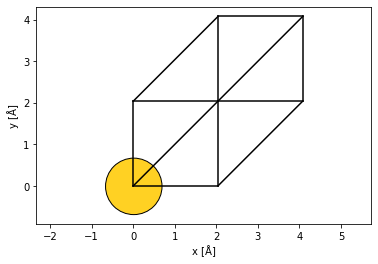

In [15]:
au_atoms = bulk('Au')

show_atoms(au_atoms)

In [16]:
cut_box(au_atoms, box=(5,5,5))

NameError: name 'cut_box' is not defined

## Choosing a propagation direction

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

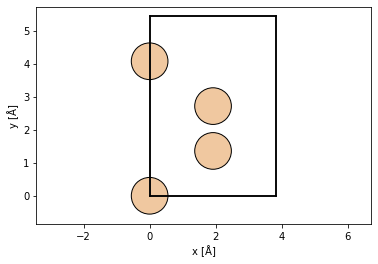

In [37]:
from ase.build import bulk, surface
from abtem.structures import standardize_cell

si = bulk('Si', 'diamond', a=5.43)

si_110 = surface(si, indices=(1, 1, 0), layers=2, periodic=True)

si_110.rotate(90, 'x', rotate_cell=True)

si_110 = standardize_cell(si_110)

show_atoms(si_110)

## 